In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing the required libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans


**Loading the dataset and preprocessing it**

(1) Load Dataset: Imports the dataset from a CSV file.

(2) Drop Unnecessary Columns: Remove the columns that are not required for analysis.

(3) Encode Categorical Feature: Convert the status_type column from categorical to numerical form.

(4) Feature Scaling: Apply scaling to all features to normalize data.

(5) DataFrame Conversion: Convert the scaled data back into a pandas DataFrame.
(6) Save Processed Data: Save the processed data to a new CSV file for future use.

In [ ]:
# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/dataset/Live.csv')

# Drop unnecessary columns
data_cleaned = data.drop(['Column1', 'Column2', 'Column3', 'Column4', 'status_id', 'status_published'], axis=1)

# Encode the 'status_type' categorical feature
label_encoder = LabelEncoder()
data_cleaned['status_type'] = label_encoder.fit_transform(data_cleaned['status_type'])

# Feature scaling
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_cleaned)

# Convert scaled data back to a DataFrame (for convenience with column names)
data_scaled = pd.DataFrame(data_scaled, columns=data_cleaned.columns)

# Save the scaled data to a new CSV file in your specified directory
data_scaled.to_csv('/content/drive/MyDrive/dataset/Live_scaled.csv', index=False)


**Elbow plot to determine number of clusters**

(1) Load Scaled Data: Reads the scaled dataset from a CSV file.

(2) Select Features: Chooses specific features (num_reactions and num_comments) for clustering.

(3) Elbow Method: Calculates and plots the Within-Cluster Sum of Squares (WCSS) for 1 to 10 clusters to determine the optimal number of clusters.

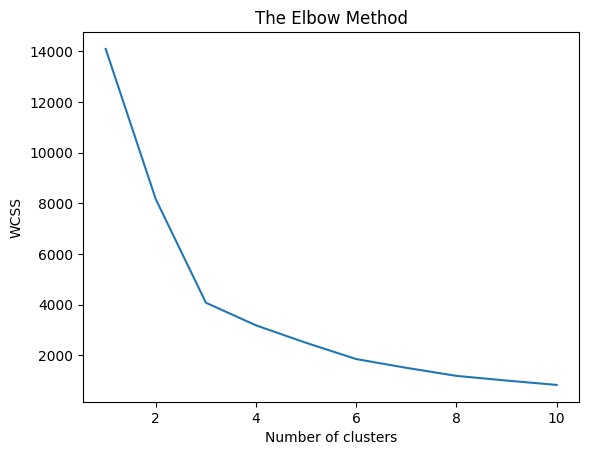

In [ ]:
# Assuming you've saved the cleaned data to 'cleaned_data.csv'
data_scaled = pd.read_csv('/content/drive/MyDrive/dataset/Live_scaled.csv')

# Select features for clustering
X = data_scaled[['num_reactions', 'num_comments']].values

# Apply the Elbow Method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


This process uses the Elbow Method to find the most appropriate number of clusters for K-means clustering, aiming to ensure that each cluster is distinct and meaningful without having too many clusters complicating the model. The method helps balance between too few clusters (underfitting) and too many (overfitting).

In [ ]:
!pip install kneed

**Choosing optimal number of clusters**

(1) KneeLocator Usage: Employ KneeLocator to automatically identify the elbow point from the WCSS values.

(2) Optimal Clusters Identification: Determine and print the optimal number of clusters based on the elbow point.

(3) Visual Confirmation: Plot WCSS against the number of clusters for visual verification, highlighting the elbow point.

The optimal number of clusters: 3


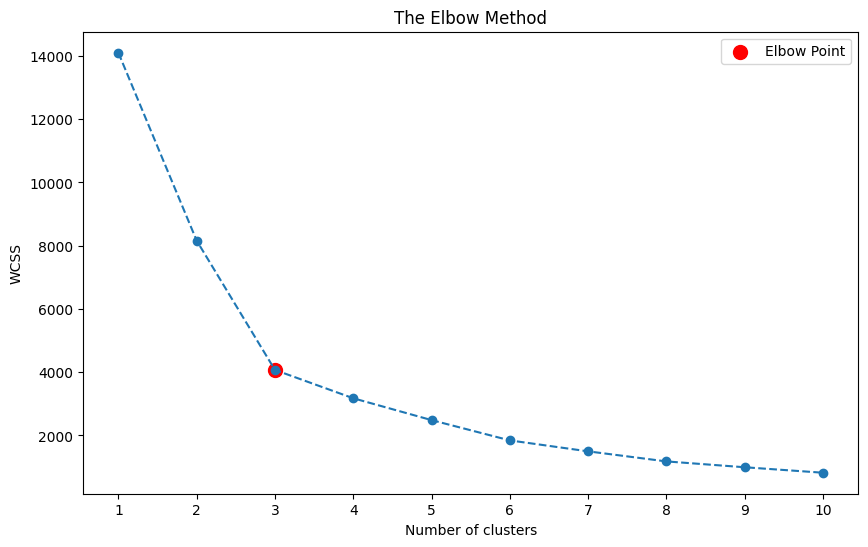

In [ ]:
from kneed import KneeLocator
import matplotlib.pyplot as plt

# Number of clusters range
range_n_clusters = range(1, 11)

# Find the elbow point
knee_locator = KneeLocator(range_n_clusters, wcss, curve='convex', direction='decreasing')

# Optimal number of clusters
optimal_clusters = knee_locator.elbow

print(f"The optimal number of clusters: {optimal_clusters}")

# Plotting for visual verification
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, wcss, marker='o', linestyle='--')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.xticks(range_n_clusters)

# Highlight the elbow point
plt.scatter(optimal_clusters, wcss[optimal_clusters-1], color='red', s=100, label='Elbow Point')

plt.legend()
plt.show()


**K-means clustering**

(1) K-means Clustering: Execute K-means clustering on your data with 3 clusters, using the 'k-means++' method for initializing centroids, running 10 initializations to choose the best one, and setting a random state for reproducibility.

(2) Cluster Prediction: Apply the trained K-means model to predict the cluster labels for each data point in X, effectively grouping the data into 3 clusters.

(3) Cluster Visualization: Create a scatter plot to visually represent the clustering result, with data points colored based on their assigned cluster. Each of the 3 clusters is represented by a different color.

(4) Centroids Plotting: Mark the centroids of the clusters with yellow dots on the scatter plot, indicating the center of each cluster.







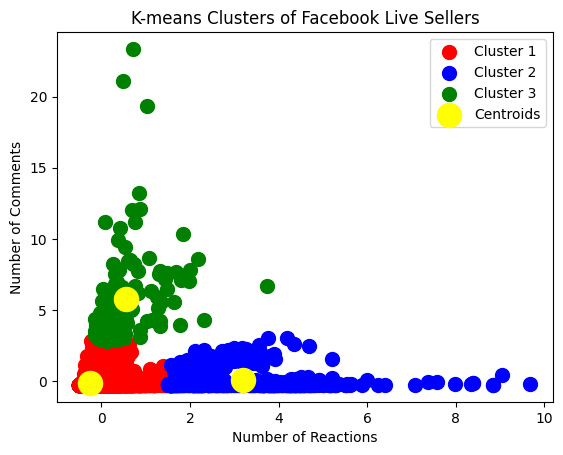

In [ ]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=42)
y_kmeans = kmeans.fit_predict(X)

# Visualize the clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s=100, c='blue', label='Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s=100, c='green', label='Cluster 3')

# Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='yellow', label='Centroids')
plt.title('K-means Clusters of Facebook Live Sellers')
plt.xlabel('Number of Reactions')
plt.ylabel('Number of Comments')
plt.legend()
plt.show()


In [ ]:
# Add cluster labels to the original cleaned data (not scaled)
data_cleaned['Cluster'] = y_kmeans

# Ensure this uses the original, unscaled 'data_cleaned' with 'Cluster' labels assigned
for cluster in sorted(data_cleaned['Cluster'].unique()):
    cluster_data = data_cleaned[data_cleaned['Cluster'] == cluster]
    # Find the encoded majority status_type, ensuring to work with non-scaled, encoded values
    majority_status_encoded = cluster_data['status_type'].mode()[0]

    # Decode the majority status_type
    majority_status = label_encoder.inverse_transform([int(majority_status_encoded)])[0]

    print(f"Majority status_type in Cluster {cluster}: {majority_status}")


Majority status_type in Cluster 0: photo
Majority status_type in Cluster 1: photo
Majority status_type in Cluster 2: video


**Using the dendrogram to find the optimal number of clusters**


To determine the number of clusters from a dendrogram, we look for the longest vertical lines that aren't crossed by an extended horizontal line (representing a cut) and count the vertical lines that intersect the horizontal line at that level.

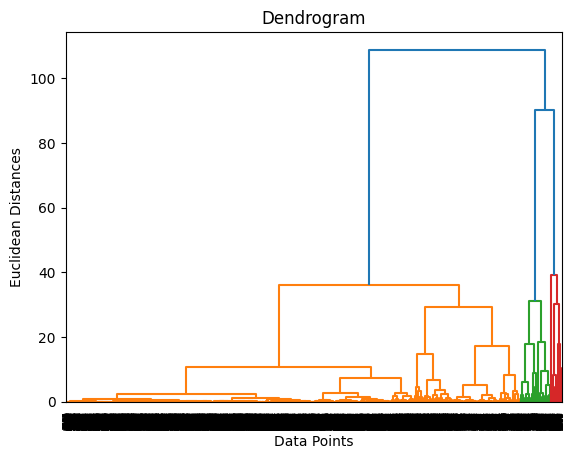

In [ ]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Create a dendrogram
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distances')
plt.show()

From the plot, the longest vertical line without a horizontal line crossing it seems to be the one connected at the top of the blue cluster lines. If we draw a horizontal line at a height just below the merge point of this blue line, it intersects with three vertical lines, suggesting that the optimal number of clusters for this dataset could be 3.

**Training the Hierarchical Clustering model on the dataset**

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Perform hierarchical clustering
hc = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
y_hc = hc.fit_predict(X)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


**Visualizing the clusters**

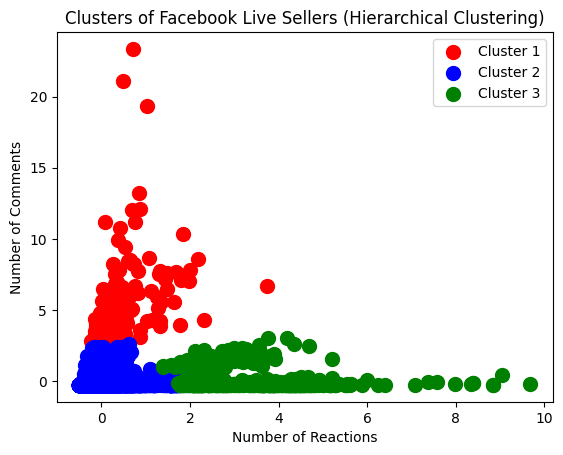

In [ ]:
# Visualize the clusters
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s=100, c='blue', label='Cluster 2')
plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s=100, c='green', label='Cluster 3')
plt.title('Clusters of Facebook Live Sellers (Hierarchical Clustering)')
plt.xlabel('Number of Reactions')
plt.ylabel('Number of Comments')
plt.legend()
plt.show()


**Majority status type in each cluster**

In [ ]:
# Add the cluster labels to your original dataset
data['Cluster'] = y_hc

# Label encode 'status_type' to revert back to original categorical types for majority voting
label_encoder = LabelEncoder()
data['status_type_encoded'] = label_encoder.fit_transform(data['status_type'])

# Calculate the majority 'status_type' for each cluster
for i in range(3):  # assuming 3 clusters
    cluster_group = data[data['Cluster'] == i]
    majority_status = cluster_group['status_type'].value_counts().idxmax()
    print(f"Majority status_type in Cluster {i}: {majority_status}")

Majority status_type in Cluster 0: video
Majority status_type in Cluster 1: photo
Majority status_type in Cluster 2: photo
